(47500, 32, 32, 32)


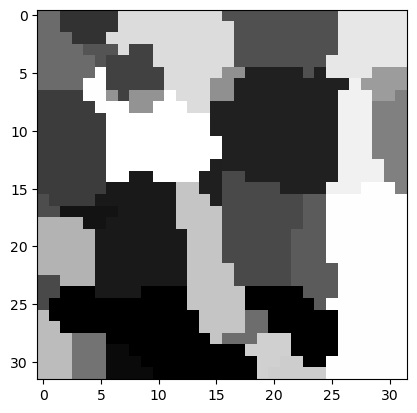

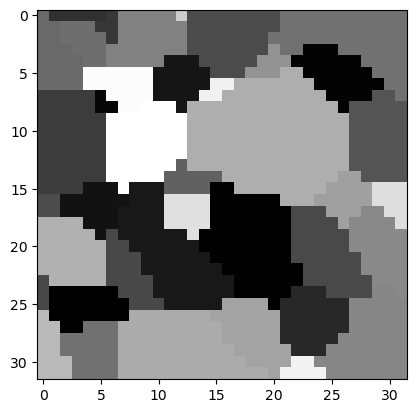

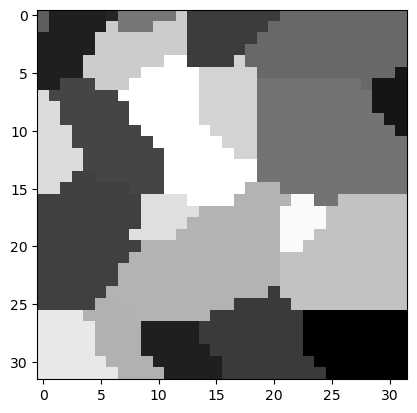

In [2]:
import numpy as np
import os
import gdown
from glob import glob
from matplotlib import pyplot as plt

# if glob("X_train.npy") == [] and glob("X_test.npy") == []:
#     gdown.download('https://drive.google.com/uc?id=1LP2zU1W1bKJZ1tew2_8MrkM1uWKRhcFM')
#     gdown.download('https://drive.google.com/uc?id=17-HIUf6aZBSddGCztofiESBAAzfG5_aI')
# Load all of the processed data
npy_train = np.load("/home/nathanielhoffman/Desktop/MS_gen_aniso_cleaned/ansio_train.npy").astype(np.float16)
npy_test = np.load("/home/nathanielhoffman/Desktop/MS_gen_aniso_cleaned/ansio_test.npy").astype(np.float16)[:10]
print(npy_train.shape)
plt.imshow(npy_train[0, :, :, 0], cmap='gray')
plt.show()  
plt.imshow(npy_train[0, :, 0, :], cmap='gray')
plt.show()  
plt.imshow(npy_train[0, 0, :, :], cmap='gray')
plt.show()  



### Normalize

In [3]:

minmax = True
print(npy_train.shape)
if minmax:
    npy_train_min = npy_train.min()
    npy_train_max = npy_train.max()
    npy_train_norm = (npy_train - npy_train_min) / (npy_train_max - npy_train_min)
    npy_test_norm = (npy_test - npy_train_min) / (npy_train_max - npy_train_min)
else:
    npy_train_mean = npy_train.mean()
    npy_train_std = npy_train.std()
    npy_train_norm = (npy_train - npy_train_mean) / npy_train_std
    npy_test_norm = (npy_test - npy_train_mean) / npy_train_std

# plt.imshow(npy_train_norm[0,8,:,:])
# npy_train_norm -= .5
# npy_test_norm -= .5
# npy_test_norm *= 2
# npy_train_norm *= 2

# Find the mean and change to 0
means = npy_train.mean(axis=(1, 2, 3), keepdims=True)
arrays_mean_zero = npy_train - means
# Find the max absolute value after subtracting the mean
max_vals = np.abs(arrays_mean_zero).max(axis=(1, 2, 3), keepdims=True)
# Normalize to range [-1, 1]
npy_train_norm = arrays_mean_zero / max_vals

means = npy_test.mean(axis=(1, 2, 3), keepdims=True)
arrays_mean_zero = npy_test - means
# Find the max absolute value after subtracting the mean
max_vals = np.abs(arrays_mean_zero).max(axis=(1, 2, 3), keepdims=True)
# Normalize to range [-1, 1]
npy_test_norm = arrays_mean_zero / max_vals

# for i in range(10):

#     plt.imshow(npy_test_norm[i,8,:,:])
#     plt.show()
# add extra dimension after batch dimension
npy_train_norm = np.expand_dims(npy_train_norm, axis=1)
npy_test_norm = np.expand_dims(npy_test_norm, axis=1)

# # corrupt training data
# for i in range(npy_train_norm.shape[0]):
#     # get random indices to corrupt
#     indices = (np.random.random(3)*6).astype(int)
#     print(indices)
#     npy_train_norm[i,0,indices[0]:indices[0]+10,indices[1]:indices[1]+10,indices[2]:indices[2]+10] = np.random.randn(10,10,10)
#     print(npy_train_norm[i].shape)

# plt.imshow(npy_train_norm[0,0,8,:,:])

dims = (1, npy_train_norm.shape[1], npy_train_norm.shape[2], npy_train_norm.shape[3], npy_train_norm.shape[4])
print(npy_train_norm.max(), npy_train_norm.min())

(47500, 32, 32, 32)
1.0 -1.0


### Import and Setup Diffuser Config

In [ ]:
from dataclasses import dataclass
from diffusers import UNet3DConditionModel
import torch

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 8 # this does not set the batch size. Use batch_size below.
    eval_batch_size = 1  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "model_checkpoints/ddm32_small_aniso.ckpt"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

model_diffuser = UNet3DConditionModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=(32,64),  # the number of output channes for each UNet block
    norm_num_groups=32,  # the number of groups for the group normalization layers
    cross_attention_dim=1,  # the dimension of the cross-attention layers
    attention_head_dim = 1,
    down_block_types=(

        # "DownBlock3D",
        "DownBlock3D",
        # "CrossAttnDownBlock3D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock3D",
    ),
    up_block_types=(
        # "UpBlock3D",  # a regular ResNet upsampling block
        # "CrossAttnUpBlock3D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock3D",
        "UpBlock3D",

      ),
)

B_test = 5
encoder_hidden_states=torch.ones((B_test,1,1))
T_test = 100
# dummy input
x_test = torch.randn(B_test, 1, 32, 32, 32)
t_test = torch.randint(0, T_test, (B_test,), device='cpu').long()
print("x_test shape:", x_test.shape)
print("t_test shape:", t_test.shape)
model_diffuser
# Dummy forward pass
y = model_diffuser(x_test, t_test, encoder_hidden_states).sample
print("y shape:", y.shape)
print("Num params: ", sum(p.numel() for p in model_diffuser.parameters()))

2025-03-19 05:58:07.951378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-19 05:58:08.626221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


x_test shape: torch.Size([5, 1, 32, 32, 32])
t_test shape: torch.Size([5])
y shape: torch.Size([5, 1, 32, 32, 32])
Num params:  1098769


### Define Forward Schedule

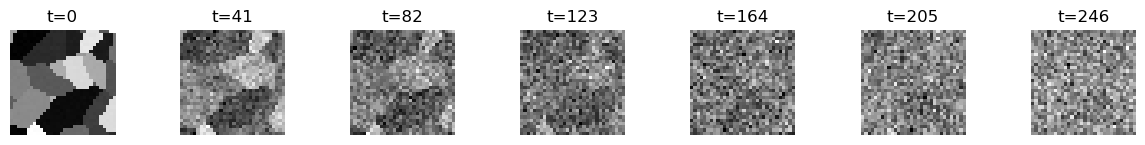

In [5]:
import importlib
import torch 
import plotting
import ddm_utils
importlib.reload(plotting)
importlib.reload(ddm_utils)
from ddm_utils import DiffusionSampler, beta_schedule
from plotting import show_forward_process, sample_plot_image
from torch.utils.data import DataLoader, Dataset
train_dataset = torch.from_numpy(npy_train_norm)
test_dataset = torch.from_numpy(npy_test_norm)
forward_plotter = DataLoader(npy_train_norm, batch_size=1, shuffle=False)

## Schedule Parameters
T = 250 # Number of timesteps
start = 1e-4 # Starting variance 
end = 0.02 # Ending variance
# Choose a schedule (if the following are False, then a linear schedule is used)
cosine = False # Use cosine schedule
exp_biasing = False # Use exponential schedule
exp_biasing_factor = 1 # Exponential schedule factor (used if exp_biasing=True)
##


## Plotting Parameters
T_m = T # Number of timesteps to plot
num_images = 6 # Number of images to plot
show_entire_batch = False
random = False
non_random_idx = 15
##

if show_entire_batch:
    image = next(iter(forward_plotter))
else:
    if random:
        idx = np.random.randint(0,forward_plotter.__len__())  
    else: 
        idx = non_random_idx
    image = train_dataset[idx].unsqueeze(0)

# Choose a variance schedule

betas = beta_schedule(T=T, start=start, end=end,
                       scale= 1.0, cosine=cosine, 
                       exp_biasing=exp_biasing, exp_bias_factor=exp_biasing_factor
                       )

ddm_sampler = DiffusionSampler(T, betas)
forward_fcn = ddm_sampler.forward_diffusion_sample
show_forward_process(image,forward_fcn,T_m=T, num_images=6)

### Initialize Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import importlib
# import unet3d_model
# importlib.reload(unet3d_model)
# from unet3d_model import UnetModel
from diffusers import UNet3DConditionModel


# Settings:
save_ddm = True # Whether to save the ddm
load_ddm = False # Whether to load a pretrained ddm
batch_size = 4 # Batch size
print("batch_size:", batch_size)
n_epochs = 10 # Number of epochs to train for
stat_interval = 10 # How often to calculate the loss statistics
plot_interval = 10 # How often to plot the loss statistics
save_interval = 10 # How often to save the model and stats
save_plots = True # Whether to save the diffusion plots
clear_animations = True # Whether to clear the animation folder
animate_path = 'results/' # Path to save the animation
ddm_save_path = 'model_checkpoints/ddm32_small_aniso.ckpt' # Path to save the model
ddm_load_path = 'model_checkpoints/ddm32_small_aniso.ckpt' # Path to load the model 
ddm_stats_path = 'model_checkpoints/ddm_stats32_small_aniso.pth' # Path to save the autoencoder stats\
mp_mode = False # Whether to use mixed precision
pre_load = False # Whether to pre-load the data onto the GPU

# Plotting/animation parameters:
T_anim = T # Number of timesteps to diffuse
plot_images = 5 # Number of images to plot

# Parameters for the diffusion process
# model_depth=4
# final_activation="gelu" 
# block_activation="gelu"
# time_activation="gelu"
# time_dim=64

# Parameters for the optimizer
lr = 1e-4 # Learning rate

# Clear all png files in the animation folder
if clear_animations:
    import os, glob
    for f in glob.glob(animate_path+'/*.png'):
        os.remove(f)

if load_ddm:
    model_diffuser = torch.load(ddm_load_path, map_location='cuda:'+str(1))
    print('Loaded model from', ddm_load_path)

    # Load stats:
    ddm_stats = torch.load(ddm_stats_path)
    epoch_start = ddm_stats['epoch']
    current_loss = ddm_stats['current_loss']
    test_loss = ddm_stats['test_loss']
    train_loss = ddm_stats['train_loss']
    test_loss_epoch = ddm_stats['test_loss_epoch']
    train_loss_epoch = ddm_stats['train_loss_epoch']
else:
    epoch_start = 0
    current_loss = 999999
    test_loss = np.array([])
    train_loss = np.array([])
    test_loss_epoch = np.array([])
    train_loss_epoch = np.array([])
    model_diffuser = UNet3DConditionModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=1,  # the number of input channels, 3 for RGB images
        out_channels=1,  # the number of output channels
        layers_per_block=1,  # how many ResNet layers to use per UNet block
        block_out_channels=(32,64),  # the number of output channes for each UNet block
        cross_attention_dim=1,  # the dimension of the cross-attention layers
        attention_head_dim = 1,
        norm_num_groups=32,  # the number of groups for the group normalization layers
        down_block_types=(
            # "DownBlock3D",
            "DownBlock3D",
            # "CrossAttnDownBlock3D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock3D",
        ),
        up_block_types=(
            # "UpBlock3D",  # a regular ResNet upsampling block
            "UpBlock3D",
            # "CrossAttnUpBlock3D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock3D",
        ),
    )

    print('Created new model')

device = "cuda:1"
model_diffuser.to('cpu')
# Loss function
def ddm_loss_fn(noise_pred, noise):
    return F.l1_loss(noise_pred, noise)
B_test = 5
encoder_hidden_states=torch.ones((B_test,1,1))
T_test = 100
# dummy input
x_test = torch.randn(B_test, 1, 32, 32, 32)
t_test = torch.randint(0, T_test, (B_test,), device='cpu').long()
print("x_test shape:", x_test.shape)
print("t_test shape:", t_test.shape)

# Dummy forward pass
y = model_diffuser(x_test, t_test, encoder_hidden_states).sample
print("y shape:", y.shape)
print("Num params: ", sum(p.numel() for p in model_diffuser.parameters()))

batch_size: 4
Created new model
x_test shape: torch.Size([5, 1, 32, 32, 32])
t_test shape: torch.Size([5])
y shape: torch.Size([5, 1, 32, 32, 32])
Num params:  1098769


### Train The Model

Training on cuda:1 for 10 epochs


11874it [36:50,  5.49it/s]

Epoch 0, Loss = 0.13942058384418488, Compute Time = 920.58 s, Total Time = 2210.40 s
Saved model to model_checkpoints/ddm32_ansio_fixed.ckpt
Saved stats to model_checkpoints/ddm_stats32_ansio_fixed.pth


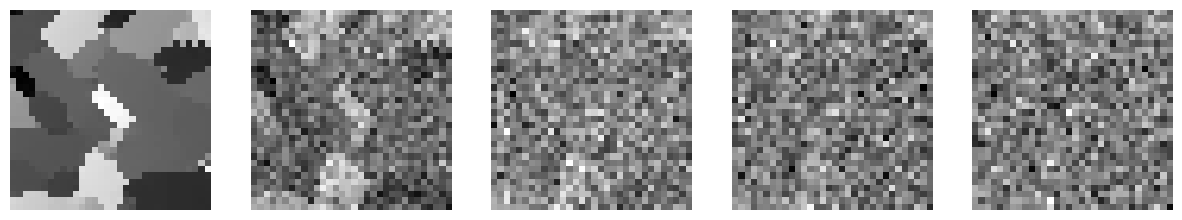

11875it [36:54,  5.36it/s]


Epoch 0, Loss = 0.13942058384418488


11875it [36:37,  5.40it/s]


Epoch 1, Loss = 0.11910241842269897


11875it [36:02,  5.49it/s]


Epoch 2, Loss = 0.10603567957878113


11875it [36:01,  5.49it/s]


Epoch 3, Loss = 0.12162557989358902


11875it [36:02,  5.49it/s]


Epoch 4, Loss = 0.13662993907928467


11875it [36:02,  5.49it/s]


Epoch 5, Loss = 0.11710134148597717


11875it [36:04,  5.49it/s]


Epoch 6, Loss = 0.120234414935112


11875it [36:05,  5.48it/s]


Epoch 7, Loss = 0.12198726832866669


11875it [36:05,  5.48it/s]


Epoch 8, Loss = 0.10888348519802094


11875it [36:05,  5.48it/s]


Epoch 9, Loss = 0.12526839971542358


11874it [36:05,  5.46it/s]

Epoch 10, Loss = 0.12424638122320175, Compute Time = 9597.36 s, Total Time = 26098.34 s
Saved model to model_checkpoints/ddm32_ansio_fixed.ckpt
Saved stats to model_checkpoints/ddm_stats32_ansio_fixed.pth


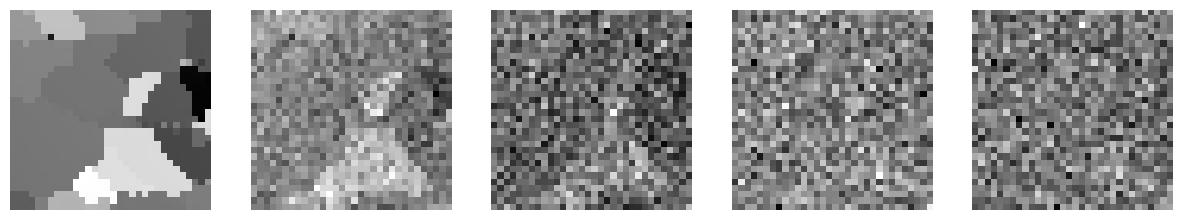

11875it [36:09,  5.47it/s]

Epoch 10, Loss = 0.12424638122320175
Total training time: 23891.45 s
Saved model to model_checkpoints/ddm32_ansio_fixed.ckpt
Saved stats to model_checkpoints/ddm_stats32_ansio_fixed.pth


In [7]:
import time
from tqdm import tqdm
torch.cuda.empty_cache()
print(f"Training on {device} for {n_epochs} epochs")
model_diffuser.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model_diffuser.parameters(), lr=lr)

# Create the data loader
if pre_load:
    train_dataset.to(device)
    test_dataset.to(device)
else:
    train_dataset.to('cpu')
    test_dataset.to('cpu')

train_loader = DataLoader(train_dataset.float(), batch_size=batch_size, shuffle=True)

# Test loader (for calculating test loss)
B_test = test_dataset.shape[0]
test_loader = DataLoader(test_dataset.float(), batch_size=B_test, shuffle=False)

# Mixed precision
if mp_mode:
    scaler = torch.cuda.amp.GradScaler()

time_elapsed = 0
total_time = 0
start_training = time.time()

# Training loop
model_diffuser.train()
for epoch in range(epoch_start, n_epochs+epoch_start+1):
    for i, x in tqdm(enumerate(train_loader)):
        # measure data loading time
        start = time.time()

        # Zero the parameter gradients
        optimizer.zero_grad()

        if not pre_load:
            x = x.to(device)


        current_batch_size = x.shape[0]
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        encoder_hidden_states=torch.ones((current_batch_size,1,1)).to(device)

        # print("x shape:", x.shape)
        # print("t shape:", t.shape)

        # Get the noise and the noisy input
        x_noisy, noise = ddm_sampler.forward_diffusion_sample(x, t, device)

        # Forward pass
        if mp_mode:
            with torch.cuda.amp.autocast(dtype=torch.float16):
                noise_pred = model_diffuser(x_noisy, t, encoder_hidden_states).sample
                loss = ddm_loss_fn(noise_pred, noise)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            noise_pred = model_diffuser(x_noisy, t, encoder_hidden_states).sample
            loss = ddm_loss_fn(noise_pred, noise)

            # Backpropagation
            loss.backward()
            optimizer.step()

        # measure elapsed time
        end = time.time()
        time_elapsed += end - start

        # Update statistics
        current_loss = loss.item()
        train_loss = np.append(train_loss, current_loss)
        train_loss_epoch = np.append(train_loss_epoch, epoch+1)
        # save at the end of each epoch
        if epoch % stat_interval == 0 and i == len(train_loader)-1:
            # measure total time
            end_training = time.time()
            total_time += end_training - start_training
            print(f"Epoch {epoch}, Loss = {current_loss}, Compute Time = {time_elapsed:.2f} s, Total Time = {total_time:.2f} s")
            # calculate test loss
            with torch.no_grad():
                for j, x_test in enumerate(test_loader):
                    
                    if not pre_load:
                        x_test = x_test.to(device)
                        

                    current_test_batch_size = x_test.shape[0]
                    t_test = torch.randint(0, T, (current_test_batch_size,), device=device).long()
                    encoder_hidden_states_test=torch.ones((current_test_batch_size,1,1)).to(device)

                    # Get the noise and the noisy input
                    x_noisy_test, noise_test = ddm_sampler.forward_diffusion_sample(x_test, t_test, device)
                    # print(indices)
                    # npy_train_norm[i,0,indices[0]:indices[0]+10,indices[1]:indices[1]+10,indices[2]:indices[2]+10] = np.ones(10,10,10)
                    # x_noisy_masked = sample_mask(x_noisy) # mask the noisy image
                    # noise_masked = sample_mask(noise) # mask the noise

                    # Forward pass
                    noise_pred_test = model_diffuser(x_noisy_test, t_test, encoder_hidden_states_test).sample
                    loss = ddm_loss_fn(noise_pred_test, noise_test)

                    # Update statistics
                    test_loss = np.append(test_loss, loss.item())
                    test_loss_epoch = np.append(test_loss_epoch, epoch+1)\
        
        # Save the model
        if epoch % save_interval == 0 and i == len(train_loader)-1:
            torch.save(model_diffuser, ddm_save_path)
            print('Saved model to', ddm_save_path)

            # Save stats:
            ddm_stats = {'epoch': epoch+1,
                        'current_loss': current_loss,
                        'test_loss': test_loss,
                        'train_loss': train_loss,
                        'test_loss_epoch': test_loss_epoch,
                        'train_loss_epoch': train_loss_epoch}
            torch.save(ddm_stats, ddm_stats_path)
            print('Saved stats to', ddm_stats_path)

        # Plot the diffusion process 
        if epoch % plot_interval == 0 and i == len(train_loader)-1:
            # pick a random set of parameters from the test set
            idx = np.random.randint(0, len(test_dataset))
            with torch.no_grad():
                sample_plot_image(model_diffuser, epoch, ddm_sampler.sample_timestep,
                        dims=dims, num_images=plot_images, T=T_anim,
                        save=save_plots, save_path=animate_path,
                        device=device,
                        )
        
    print(f"Epoch {epoch}, Loss = {current_loss}")
    # measure total time
    end_training = time.time()


# measure total time
end_training = time.time()
total_time = end_training - start_training
print(f"Total training time: {total_time:.2f} s")
torch.save(model_diffuser, ddm_save_path)
print('Saved model to', ddm_save_path)

# Save the stats
ddm_stats = {'epoch': epoch, 'current_loss': current_loss, 'test_loss': test_loss, 'train_loss': train_loss,
            'test_loss_epoch': test_loss_epoch, 'train_loss_epoch': train_loss_epoch}
torch.save(ddm_stats, ddm_stats_path)
print('Saved stats to', ddm_stats_path)
